<a href="https://colab.research.google.com/github/cbeckler/eco_cancer_incidence_rates/blob/main/Machine%20Learning%20Model/Visualization_Balanced_Random_Forest_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:14 http://security.ubuntu.com/ubuntu fo

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2023-01-20 19:03:55--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.08s   

2023-01-20 19:03:55 (11.6 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
# start spark session 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("balanced_random_forest").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#connect to database

import pandas as pd

conn_path = "/content/drive/MyDrive/Data/db_conn_info.csv"

conn_info = pd.read_csv(conn_path)

db_name = conn_info['db_name'][0]

db_pw = conn_info['password'][0]

db_host = conn_info['host'][0]

db_port = conn_info['port'][0]

db_user = conn_info['user'][0]

In [6]:
from sqlalchemy import create_engine

engine = create_engine(f'postgresql://{db_name}:{db_pw}@{db_host}:{db_port}/{db_user}')

In [7]:
# import model dataset

df = pd.read_sql("select * from model_dataset", engine)

df.head()

,index,FIPS,recent_trend,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0,1101,falling,12.555164,12.013325,11.958884,41.874165,39.939759,39.977164,13.365598,...,40.567937,43.333084,43.589498,40.750847,36.326936,41.478252,41.055674,39.470118,36.512861,37.457633
1,1,1103,stable,13.287901,12.684610,12.647047,43.308170,41.901690,41.888594,15.564124,...,43.226680,44.786660,46.470120,42.158683,38.435499,42.927004,42.164915,41.937580,38.473920,38.021493
2,2,1105,stable,11.426605,11.072150,11.079387,39.805057,38.986625,39.022229,12.768430,...,40.612558,43.447473,43.062623,38.970321,34.915892,39.396689,38.999311,37.908802,35.517161,35.654156
3,3,1107,stable,11.594499,11.146401,11.155309,39.979953,39.173487,39.137133,13.199240,...,41.574587,43.677365,42.648266,38.709791,35.148054,39.154417,38.971029,38.468993,36.022568,35.750203
4,4,1109,stable,11.352271,10.939546,10.932512,40.690546,39.856677,39.866958,12.164619,...,40.589950,43.572161,43.102934,40.463900,36.734288,41.022877,40.996091,38.420984,36.382191,37.127240


In [8]:
import numpy as np
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


## Create Features and target variable

In [9]:
X = df.drop(['index', 'FIPS', 'recent_trend'], axis=1)
y = df['recent_trend']

In [10]:
features=X.columns

In [11]:
y.value_counts()

stable     961
falling     68
rising      19
Name: recent_trend, dtype: int64

## Data split into Training and Testing

In [12]:
#Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)
scaler =StandardScaler().fit(X_train)

X_train_scaled =scaler.transform(X_train)
X_test_scaled =scaler.transform(X_test)

## Data resampled with SMOTE

In [13]:
# Resampling training data with SMOTE
X_resampled, y_resampled = SMOTE(
    random_state=1,sampling_strategy='auto').fit_resample(
    X_train_scaled, y_train)

print(f'y_resampled: {Counter(y_resampled)}')

y_resampled: Counter({'stable': 721, 'falling': 721, 'rising': 721})


## Balanced Random Forest Classifier 

In [14]:
from imblearn.ensemble import BalancedRandomForestClassifier
brc=BalancedRandomForestClassifier(random_state=1, n_estimators=100).fit(X_resampled, y_resampled)

In [15]:
y_pred= brc.predict(X_test_scaled)

In [16]:
y_pred_train= brc.predict(X_train_scaled)

## Balanced Accuracy Score

In [17]:
# Balanced accuracy training score 
balanced_accuracy_score(y_train, y_pred_train)

1.0

In [18]:
# Balanced accuracy testign score
balanced_accuracy_score(y_test, y_pred)


0.3491013071895425

## Confusion Matrix

In [19]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[  3,   1,  13],
       [  0,   0,   5],
       [ 24,   7, 209]])

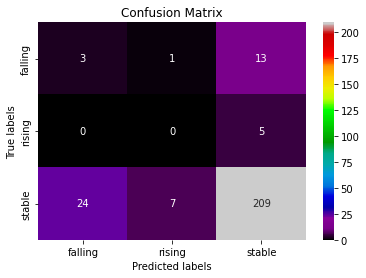

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="nipy_spectral"); #"cividis","nipy_spectral","GnBu_r","jet","PuBu_r","Spectral_r","gnuplot","gist_ncar","gist_heat_r","gist_earth_r","inferno_r","RdYlBu","coolwarm",Spectral,"PRGn","PiYG"#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['falling', 'rising','stable']); ax.yaxis.set_ticklabels(['falling', 'rising','stable']);
plt.savefig('/content/drive/MyDrive/Final_Project/confusion_matrix1.png')

In [21]:
brc_df=pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
brc_df.head()

,Prediction,Actual
0,stable,stable
1,stable,stable
2,stable,stable
3,stable,stable
4,stable,stable


In [22]:
print(brc_df.Prediction.value_counts())
print(brc_df.Actual.value_counts())

stable     227
falling     27
rising       8
Name: Prediction, dtype: int64
stable     240
falling     17
rising       5
Name: Actual, dtype: int64


## Imbalanced Classification Report

In [23]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

    falling       0.11      0.18      0.90      0.14      0.40      0.15        17
     rising       0.00      0.00      0.97      0.00      0.00      0.00         5
     stable       0.92      0.87      0.18      0.90      0.40      0.17       240

avg / total       0.85      0.81      0.24      0.83      0.39      0.16       262



# Predictions with trained model 

In [24]:
scaler =StandardScaler().fit(X)
X_scaled =scaler.transform(X)

In [25]:
prediction_trend= brc.predict(X_scaled)

In [26]:
prediction_trend

array(['stable', 'stable', 'stable', ..., 'stable', 'stable', 'stable'],
      dtype=object)

In [27]:
df.head()
# df.to_csv('/content/drive/MyDrive/Final_Project/df.csv')

,index,FIPS,recent_trend,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0,1101,falling,12.555164,12.013325,11.958884,41.874165,39.939759,39.977164,13.365598,...,40.567937,43.333084,43.589498,40.750847,36.326936,41.478252,41.055674,39.470118,36.512861,37.457633
1,1,1103,stable,13.287901,12.684610,12.647047,43.308170,41.901690,41.888594,15.564124,...,43.226680,44.786660,46.470120,42.158683,38.435499,42.927004,42.164915,41.937580,38.473920,38.021493
2,2,1105,stable,11.426605,11.072150,11.079387,39.805057,38.986625,39.022229,12.768430,...,40.612558,43.447473,43.062623,38.970321,34.915892,39.396689,38.999311,37.908802,35.517161,35.654156
3,3,1107,stable,11.594499,11.146401,11.155309,39.979953,39.173487,39.137133,13.199240,...,41.574587,43.677365,42.648266,38.709791,35.148054,39.154417,38.971029,38.468993,36.022568,35.750203
4,4,1109,stable,11.352271,10.939546,10.932512,40.690546,39.856677,39.866958,12.164619,...,40.589950,43.572161,43.102934,40.463900,36.734288,41.022877,40.996091,38.420984,36.382191,37.127240


In [28]:
df['prediction_trend'] = prediction_trend

print(df.recent_trend.value_counts())
print(df.prediction_trend.value_counts())

stable     961
falling     68
rising      19
Name: recent_trend, dtype: int64
stable     943
falling     81
rising      24
Name: prediction_trend, dtype: int64


## Feature importances

In [29]:
# List the features sorted in descending order by feature importance
features = sorted(zip(X.columns, brc.feature_importances_), reverse= True, key = lambda x: x[1])
for feature in features:
    print(f'{feature[0]}:{feature[1]}')

O3_max_pred_2004:0.036635399064819434
O3_max_pred_2009:0.02981012514591826
O3_max_pred_2013:0.02798318966923743
O3_max_pred_2014:0.025732453163736062
PM25_max_pred_2011:0.02437585844465468
O3_mean_pred_2009:0.023785086231302457
O3_med_pred_2009:0.021378841165368492
PM25_max_pred_2007:0.020001006772507896
O3_med_pred_2004:0.017656451201956507
O3_med_pred_2013:0.017036879029113956
O3_mean_pred_2004:0.016972412136163153
O3_max_pred_2008:0.016875202389400355
O3_max_pred_2006:0.016692496823690454
O3_max_pred_2007:0.015985797520319762
PM25_max_pred_2004:0.01590437883127505
O3_max_pred_2003:0.015817000207399883
O3_med_pred_2003:0.01562601029722633
O3_max_pred:0.013776557595520338
O3_mean_pred_2013:0.01373853336194578
PM25_max_pred_2005:0.013183997935669513
PM25_max_pred_2002:0.01294275296804576
O3_mean_pred_2006:0.012863375056263037
O3_max_pred_2005:0.012693949838651537
O3_med_pred_2008:0.012367077229890127
O3_mean_pred_2003:0.012091741989560768
O3_mean_pred_2014:0.011922669473033862
O3_med_p

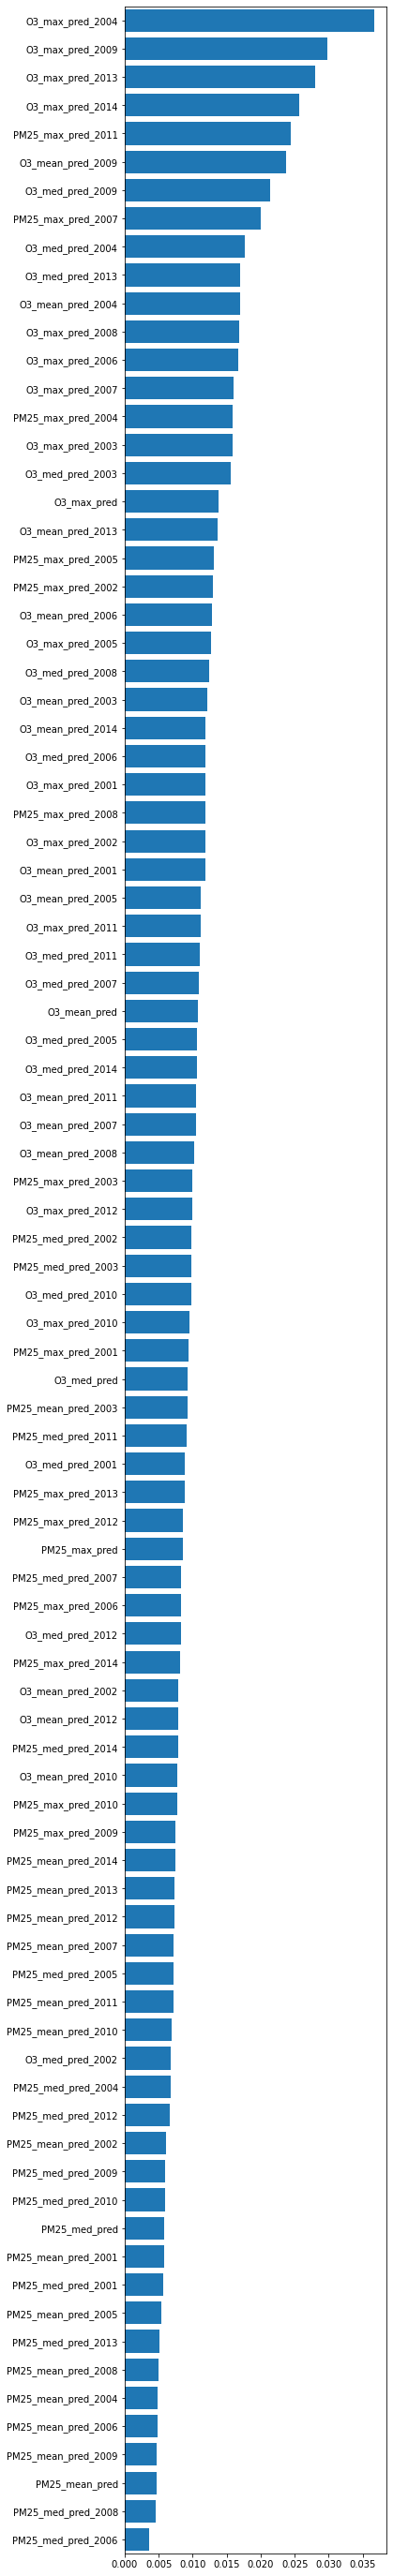

In [30]:
features = sorted(zip(X.columns, brc.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(5,50)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)
# plt.savefig('/content/drive/MyDrive/Final_Project/Feature_Importances')
plt.show()

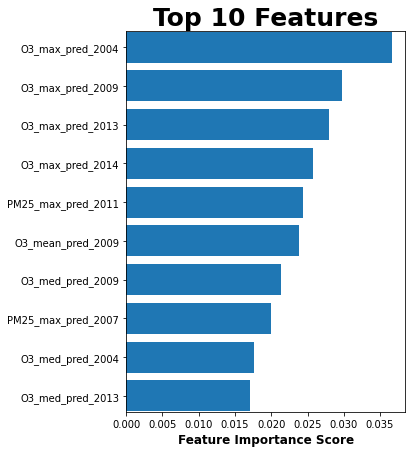

In [38]:
# graph with top 10 features
features = sorted(zip(X.columns, brc.feature_importances_), key = lambda x: x[1])

features_df = pd.DataFrame(features, columns=['feature', 'score'])

features_df = features_df.sort_values(by='score', ascending=False)

top_features = features_df.head(10)

top_features = top_features.sort_values(by='score')

cols = top_features['feature']
width = top_features['score']

fig, ax = plt.subplots()

fig.set_size_inches(5,7)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

ax.set_title("Top 10 Features",fontdict={'fontsize': 25, 'fontweight': 'semibold'})
ax.set_xlabel("Feature Importance Score",fontdict={'fontsize': 12, 'fontweight': 'semibold'})

plt.savefig('/content/drive/MyDrive/Final_Project/Feature_Importances_top10')
plt.show()

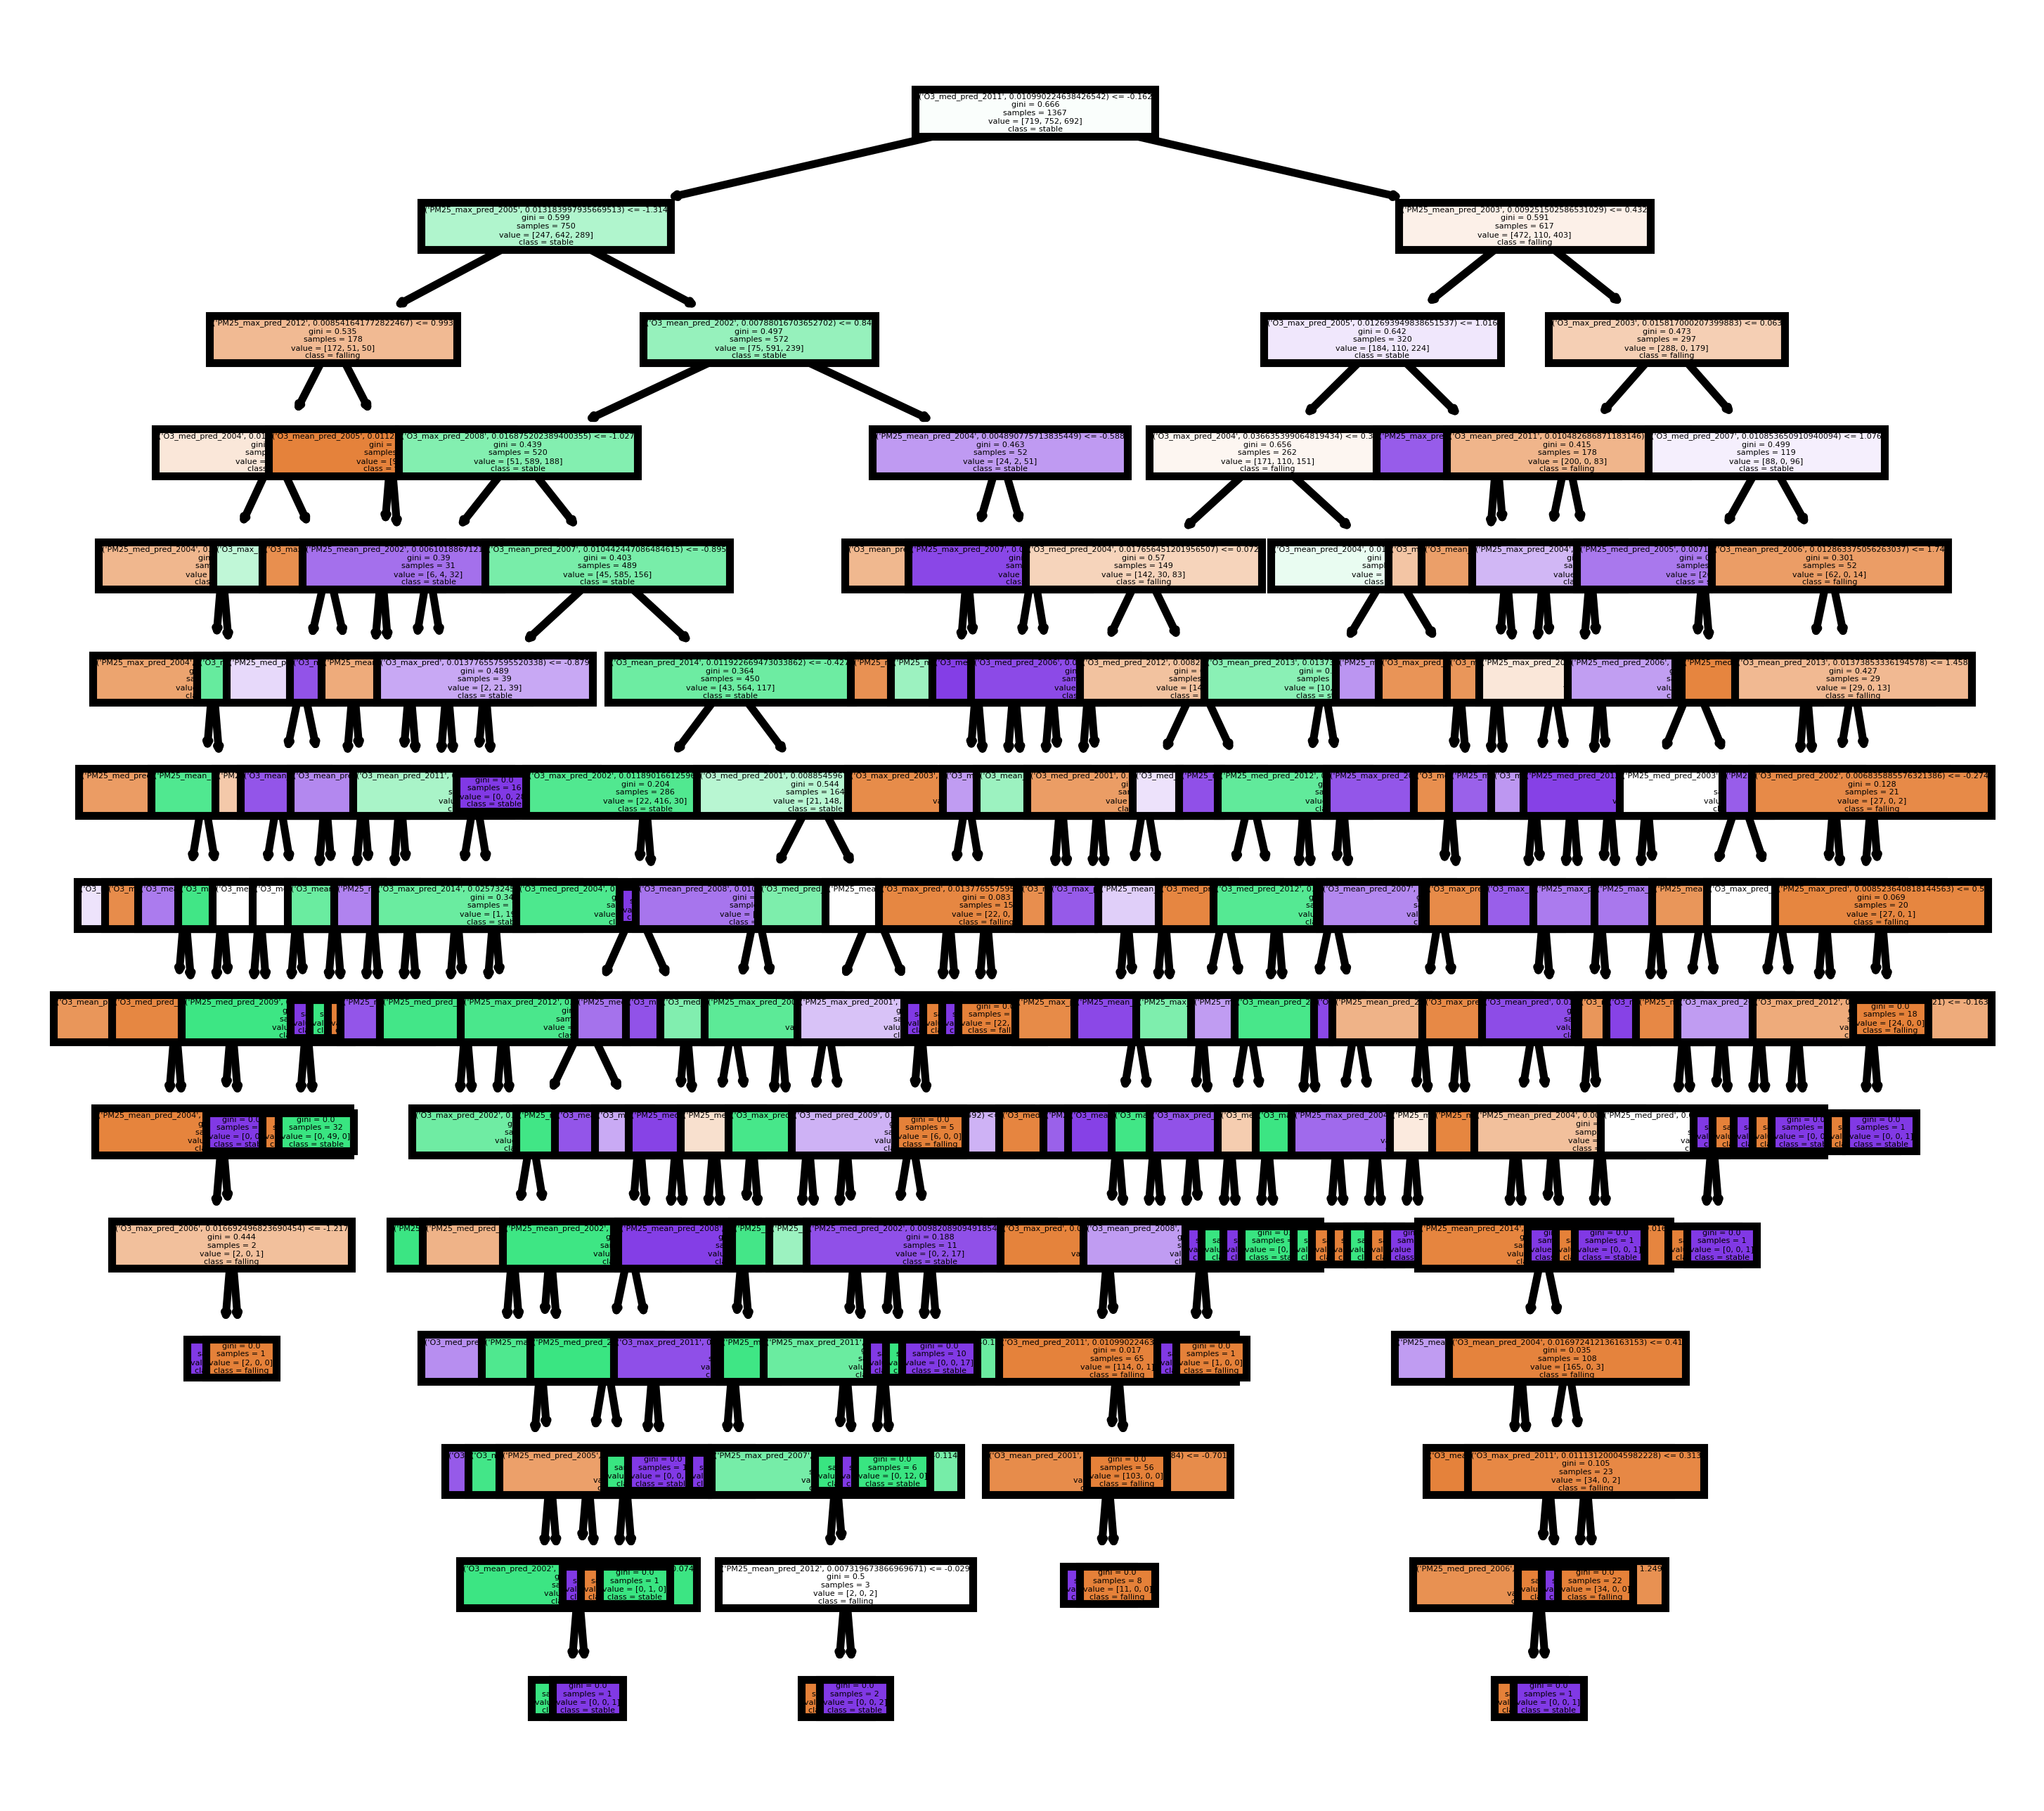

In [39]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(brc.estimators_[0],
               feature_names = features, 
               class_names=df['recent_trend'],
               filled = True);
plt.savefig('/content/drive/MyDrive/Final_Project/tree2.png')


In [33]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    brc, X_test_scaled, y_test, n_repeats=10, random_state=1, n_jobs=2)

forest_importances = pd.Series(result.importances_mean)

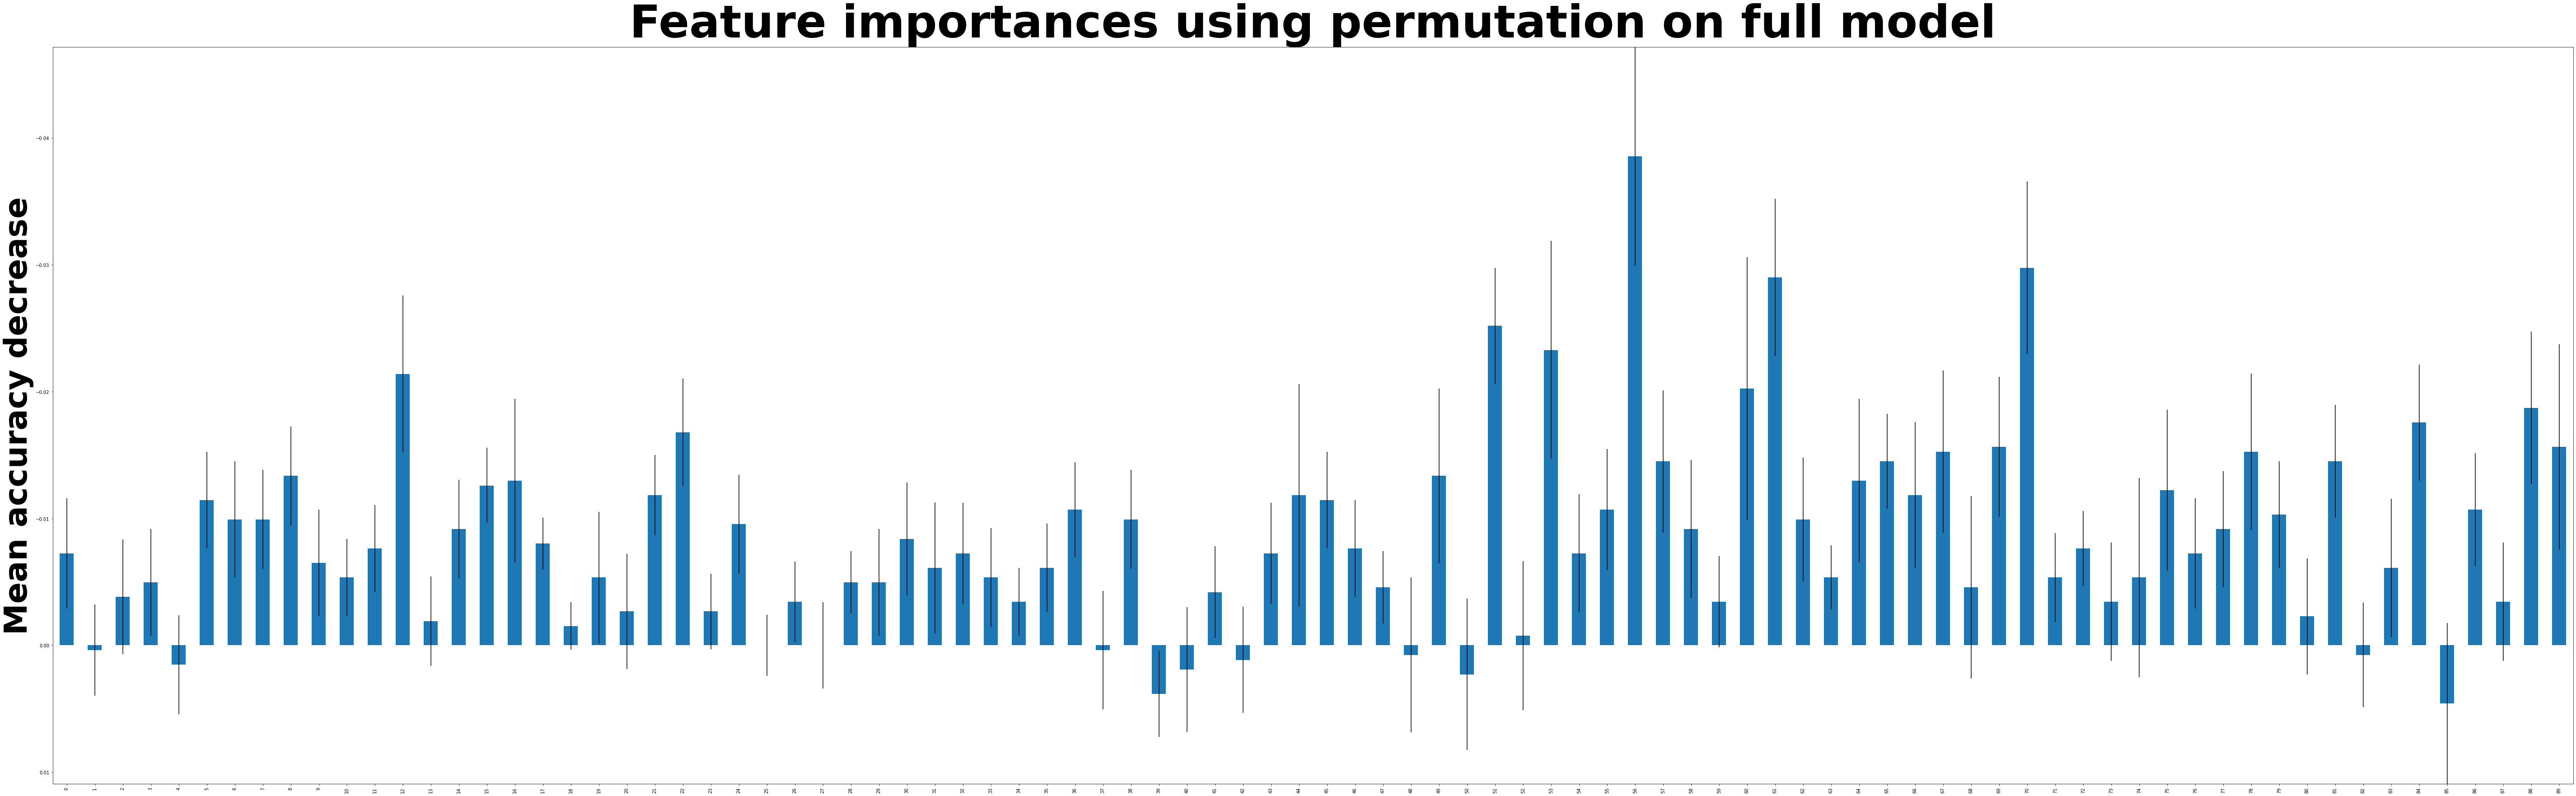

In [34]:
# import matplotlib.pylab as pylab

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model",fontdict={'fontsize': 100, 'fontweight': 'semibold'})
ax.set_ylabel("Mean accuracy decrease",fontdict={'fontsize': 70, 'fontweight': 'semibold'})
ax.invert_yaxis()
fig.set_size_inches(100,30)
plt.margins(x=0.00001,y=0.00001)


# plt.savefig('/content/drive/MyDrive/Final_Project/Forest_Importances')
plt.show()

In [35]:
# export data for visualizations

viz_cols = ['FIPS', 'recent_trend', 'prediction_trend', 'O3_max_pred', 'PM25_max_pred']

viz_df = df[viz_cols].copy()

viz_df.head()

,FIPS,recent_trend,prediction_trend,O3_max_pred,PM25_max_pred
0,1101,falling,stable,41.874165,12.555164
1,1103,stable,stable,43.308170,13.287901
2,1105,stable,stable,39.805057,11.426605
3,1107,stable,stable,39.979953,11.594499
4,1109,stable,stable,40.690546,11.352271


In [36]:
#viz_df.to_sql('visualization_data', engine, if_exists='replace', index=False)